## Importing the libraries

In [84]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ` US Arrests`

This data set contains statistics, on arrests per 100,000 residents, for assault, murder, and rape in each of the 50 US states in 1973. Also given is the percentage of the population living in urban areas

In [85]:
df = pd.read_csv('USArrests.xls')
df = df.rename(columns={'Unnamed: 0':'State'})
df.head(10)

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6
5,Colorado,7.9,204,78,38.7
6,Connecticut,3.3,110,77,11.1
7,Delaware,5.9,238,72,15.8
8,Florida,15.4,335,80,31.9
9,Georgia,17.4,211,60,25.8


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   State     50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


In [87]:
df.isnull().sum()

State       0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

## Correlation Map

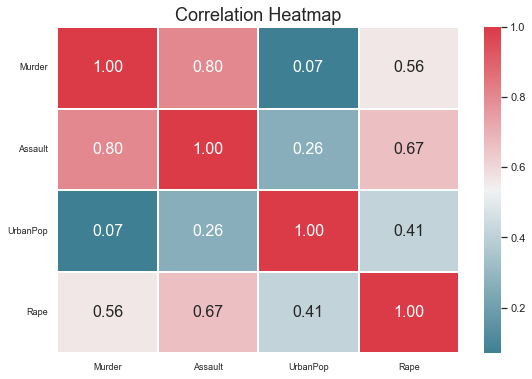

In [88]:
plt.figure(figsize=(9,6))
sns.set_theme()

colormap = sns.diverging_palette(220, 10, as_cmap=True)
corr = df.corr()

dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True

sns.heatmap(corr, annot=True, cmap=colormap,annot_kws={"size": 16}, linewidth=2, cbar=True, fmt=".2f",)
plt.title('Correlation Heatmap', size=18)
plt.xticks(size=9)
plt.yticks(size=9, rotation=0)
plt.show()

As the correlation map indicates, there isn't much correlation between variables, except between:
* Murder - Assault: __0.80__
* Rape - Assault: __0.67__
* Rape - Murder : __0.56__

So, the PCA will be applied for __3__ principal components in order to preserve the data quality for further analysis.

## `PCA - Standard Scale`

In [90]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop('State', axis=1))
df_scaled= pd.DataFrame(df_scaled)


In [91]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca)


------------------------

# `KMeans Clustering`

The __number of clusters__ has to be decided when `k-means clustering` is used, unlike hierarchical clustering. 
So let's start with creating scree plot. A scree plot is a plot between `WCSS` (Within cluster sum of squares) and number of clusters. Without sound domain knowledge or in the scenarios with unclear motives, the scree plots help us decide the number of clusters to specify.

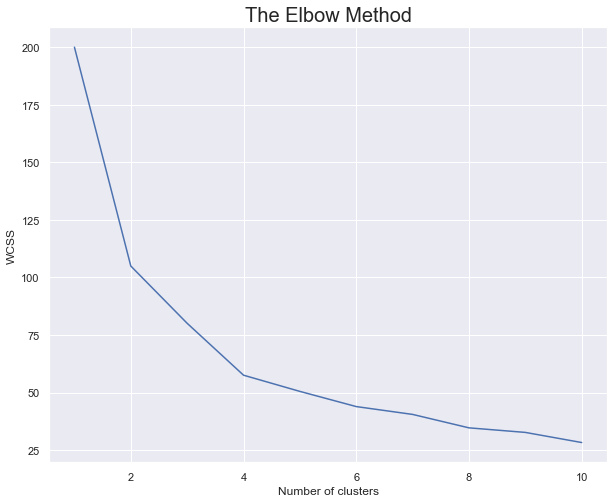

In [92]:
from sklearn.cluster import KMeans
%matplotlib inline

plt.figure(figsize=(10,8))
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,  random_state=0)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.title('The Elbow Method', size=20)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The scree plot levels off at __`k=4`__ so let's use it to determine the clusters.

In [93]:
kmeans = KMeans(n_clusters=4, random_state=0)
y_kmeans = kmeans.fit_predict(df_scaled)

# Let's name the claster from 1-4 instead 0-3 for additional clarity
y_kmeans = y_kmeans + 1
# Let's add this list to the dataframe to identify each state
cluster = list(y_kmeans)
df_kmeans = df.copy()
df_kmeans['cluster'] = cluster
df_kmeans.sample(5)

,State,Murder,Assault,UrbanPop,Rape,cluster
37,Pennsylvania,6.3,106,72,14.9,1
9,Georgia,17.4,211,60,25.8,4
7,Delaware,5.9,238,72,15.8,1
45,Virginia,8.5,156,63,20.7,1
35,Oklahoma,6.6,151,68,20.0,1


In [94]:
df_kmeans.groupby('cluster').mean().sort_values(['Assault', 'Murder', 'Rape'], ascending=False)[['Assault', 'Murder', 'Rape']]

,Assault,Murder,Rape
cluster,,,
2,257.384615,10.815385,33.192308
4,243.625000,13.937500,21.412500
1,138.875000,5.656250,18.781250
3,78.538462,3.600000,12.176923


As the previous table shows, 
* The states which belongs to cluster __`4`__ is the most violent in terms of _Murder_, but not the one with the highest values of _Assault_ and _Rape_ crimes
* The cluster number __`2`__ is the one with the highest values in _Assault_ and _Rape_, following cluster __`4`__ in terms of _Murder_
* The states from cluster __`3`__ are the one with less cases registered in all areas
* Cluster 1 is the less dangerous of the 4

This position the states in cluster __`2`__ as the most dangerous one, following by cluster __`4`__

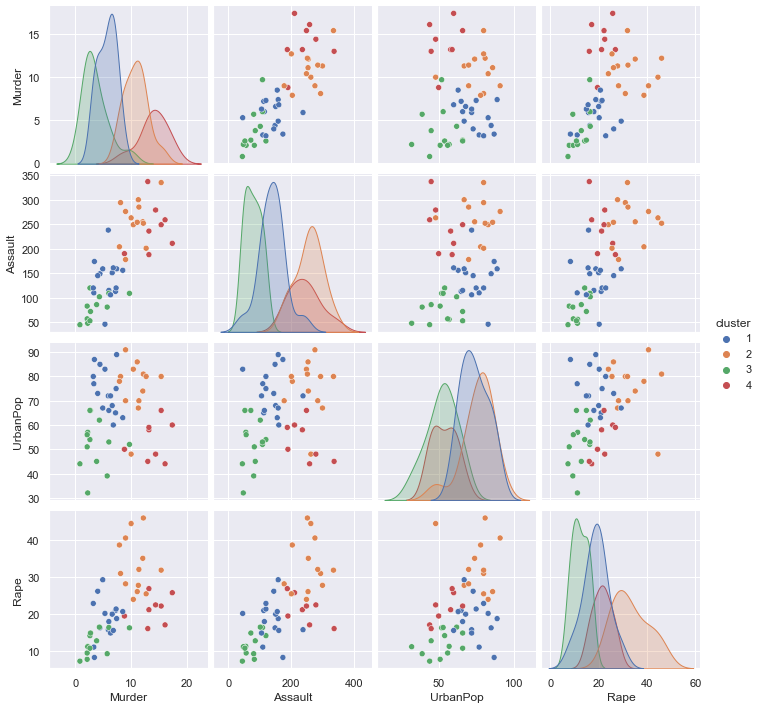

In [110]:
sns.pairplot(df_kmeans, hue='cluster', palette='deep')
plt.show()


In [96]:
''' States from cluster 2'''
df_kmeans[df_kmeans.cluster==2].sort_values(['Murder', 'Assault', 'Rape'], ascending=False).reset_index(drop=True)[['State','Murder', 'Assault', 'Rape']]

,State,Murder,Assault,Rape
0,Florida,15.4,335,31.9
1,Texas,12.7,201,25.5
2,Nevada,12.2,252,46.0
3,Michigan,12.1,255,35.1
4,New Mexico,11.4,285,32.1
5,Maryland,11.3,300,27.8
6,New York,11.1,254,26.1
7,Illinois,10.4,249,24.0
8,Alaska,10.0,263,44.5
9,California,9.0,276,40.6


In [97]:
''' States from cluster 1, the least dangerous'''
df_kmeans[df_kmeans.cluster==1].sort_values(['Murder', 'Assault', 'Rape'], ascending=False).reset_index(drop=True)[['State','Murder', 'Assault', 'Rape']]

,State,Murder,Assault,Rape
0,Virginia,8.5,156,20.7
1,New Jersey,7.4,159,18.8
2,Ohio,7.3,120,21.4
3,Indiana,7.2,113,21.0
4,Wyoming,6.8,161,15.6
5,Oklahoma,6.6,151,20.0
6,Pennsylvania,6.3,106,14.9
7,Kansas,6.0,115,18.0
8,Delaware,5.9,238,15.8
9,Hawaii,5.3,46,20.2


------------------------------------
# Clustering Method 2 : `Agglomerative Clustering`

In [117]:
from sklearn.cluster import AgglomerativeClustering

agg_clustering = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
agg_clustering.fit(df_pca)

AgglomerativeClustering(affinity='euclidean', linkage='complete', n_clusters=4)

In [118]:
y_aggcluster = agg_clustering.fit_predict(df_pca)
y_aggcluster = y_aggcluster + 1

cluster2 = list(y_aggcluster)
df_agg = df.copy()
df_agg['cluster'] = cluster2

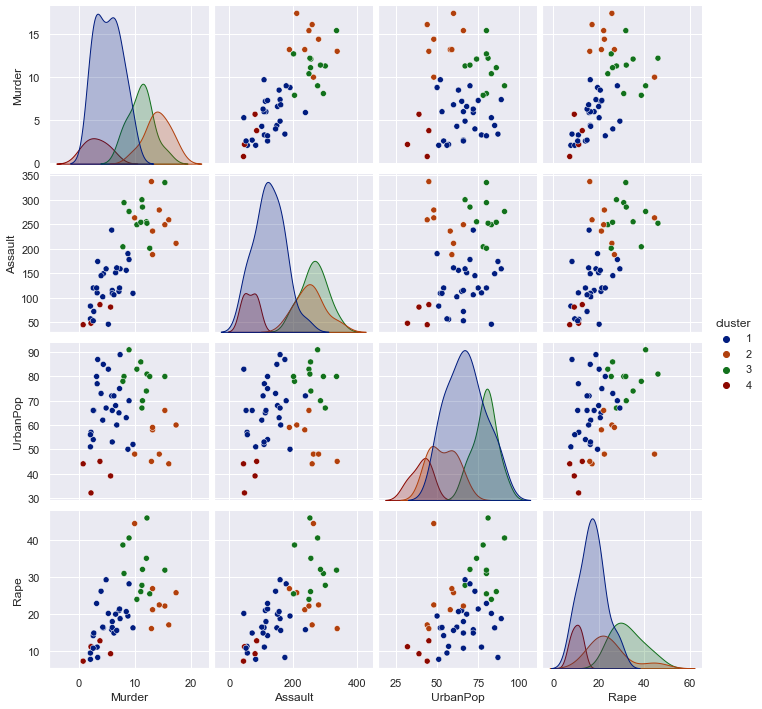

In [119]:
sns.pairplot(df_agg, hue='cluster', palette='dark')
plt.show()

------------------------

### Let's print both tables to make additional comparisons

In [100]:
print('Clusters from Agglomerative Clustering')
df_agg.groupby('cluster').mean().sort_values(['Assault', 'Murder', 'Rape'], ascending=False)

Clusters from Agglomerative Clustering


,Murder,Assault,UrbanPop,Rape
cluster,,,,
3,11.054545,264.090909,79.090909,32.618182
2,14.087500,252.750000,53.500000,24.537500
1,5.281481,124.111111,67.370370,17.255556
4,3.125000,65.000000,40.000000,10.150000


In [101]:
print('Clusters from K-Means')
df_kmeans.groupby('cluster').mean().sort_values(['Assault', 'Murder', 'Rape'], ascending=False)

Clusters from K-Means


,Murder,Assault,UrbanPop,Rape
cluster,,,,
2,10.815385,257.384615,76.000000,33.192308
4,13.937500,243.625000,53.750000,21.412500
1,5.656250,138.875000,73.875000,18.781250
3,3.600000,78.538462,52.076923,12.176923


The first thing to notice is that the index that both techniques give to each cluster are not the same, in the case of `Agglomerative Clustering` the most dangerous cluster would be the number `3` versus number `2` in `K-Means Clustering`. Despite that, the mean of each of their members doesn't differ too much. 

-----------------------

### The most __dangerous__ clusters comparison

In [102]:
df_kmeans[df_kmeans.cluster==2].sort_values(['Murder', 'Assault', 'Rape'], ascending=False).reset_index(drop=True)

,State,Murder,Assault,UrbanPop,Rape,cluster
0,Florida,15.4,335,80,31.9,2
1,Texas,12.7,201,80,25.5,2
2,Nevada,12.2,252,81,46.0,2
3,Michigan,12.1,255,74,35.1,2
4,New Mexico,11.4,285,70,32.1,2
5,Maryland,11.3,300,67,27.8,2
6,New York,11.1,254,86,26.1,2
7,Illinois,10.4,249,83,24.0,2
8,Alaska,10.0,263,48,44.5,2
9,California,9.0,276,91,40.6,2


In [103]:
df_agg[df_agg.cluster==3].sort_values(['Murder', 'Assault', 'Rape'], ascending=False).reset_index(drop=True)

,State,Murder,Assault,UrbanPop,Rape,cluster
0,Florida,15.4,335,80,31.9,3
1,Texas,12.7,201,80,25.5,3
2,Nevada,12.2,252,81,46.0,3
3,Michigan,12.1,255,74,35.1,3
4,New Mexico,11.4,285,70,32.1,3
5,Maryland,11.3,300,67,27.8,3
6,New York,11.1,254,86,26.1,3
7,Illinois,10.4,249,83,24.0,3
8,California,9.0,276,91,40.6,3
9,Arizona,8.1,294,80,31.0,3


From the above, we can see that in the `KMeans` technique, both _Alaska_ and _Missouri_ were in the most dangerous cluster, but this is not the case for `Agglomerative Clusters` , so let's see where they belong in this technique:

In [104]:
df_agg[(df_agg.State=='Alaska')|(df_agg.State=='Missouri')][['State', 'cluster']]

,State,cluster
1,Alaska,2
24,Missouri,1


Generating again the table with these clusters, we can see that cluster `2` and cluster `1` are in the middle of the table. Not the most dangerous nor the safest one, which doesn't look that conclusive since they are ranked as __Alaska: 9__ and __Missouri: 11__ in the ranking of registered crimes table from `K-Means | cluster 3`.

In [105]:
print('Clusters from Agglomerative Clustering')
df_agg.groupby('cluster').mean().sort_values(['Assault', 'Murder', 'Rape'], ascending=False)

Clusters from Agglomerative Clustering


,Murder,Assault,UrbanPop,Rape
cluster,,,,
3,11.054545,264.090909,79.090909,32.618182
2,14.087500,252.750000,53.500000,24.537500
1,5.281481,124.111111,67.370370,17.255556
4,3.125000,65.000000,40.000000,10.150000
